# Energy Market Analysis - Task 2

#### API used: [ US Energy Information Administration ](https://www.eia.gov/opendata)

In [1]:
import csv
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline


Load the data from the csv file created in Task 1 into a pandas DataFrame.

In [2]:
df = pd.read_csv('output.csv')


### Data Preprocessing
First step; rename the column headers in the data frame to more intuitive names.

#### Dataset Column Headers & Description

Below each of the column headers in the pandas data frame are explained with their corresponding [US Energy Information Administration ](https://www.eia.gov/opendata) API data description. The data is retrieved as the national monthly average for each category.

#### Electriciy Price Columns
- `elec_res` = Average Price of Electricity to Ultimate Customers, Residential in Cents per Kilowatthour (ESRCUUS)
- `elec_comm` = Average Price of Electricity to Ultimate Customers, Commercial in Cents per Kilowatthour (ESCMUUS) 
- `elec_ind` = Average Price of Electricity to Ultimate Customers, Industrial in Cents per Kilowatthour ESICUUS
- `elec_total` = Average Price of Electricity to Ultimate Customers, Total in Cents per Kilowatthour (ESTCUUS)

#### Gas Price Columns


- `gas_res` = Average Natural Gas Price, Residential in Dollars per Thousand Cubic Feet (NGRCUUS)
- `gas_comm` = Average Natural Gas Price, Commercial in Dollars per Thousand Cubic Feet (NGCCUUS)
- `gas_ind` = Average Natural Gas Price, Industrial in Dollars per Thousand Cubic Feet (NGINUUS)
- `gas_total` = Average Natural Gas Price (dollar/thousand cubic feet)

#### Energy Consumption Data
- `gas_cons_forelec` = Natural Gas Consumption for Electricity Generation, All Sectors in Billion Cubic Feet (NGEPPUS)
- `nat_gas_consum` = Natural Gas Consumption, Total in Billion Cubic Feet (NGTCPUS)
- `ren_energy_prod` = Total Renewable Energy Production in Trillion Btu (REPRBUS)
- `ren_energy_consum` = Total Renewable Energy Consumption in Trillion Btu (RETCBUS)

In [3]:
#Rename the columns so they are more intuitive than the API facet codes
df = df.rename(columns={ 'ESRCUUS' : 'elec_res' , 'ESCMUUS' : 'elec_comm', 'ESICUUS' : 'elec_ind', 
                        'ESTCUUS': 'elec_total', 'NGRCUUS' : 'gas_res', 'NGCCUUS' : 'gas_comm', 
                        'NGINUUS' : 'gas_ind', 'gas_total': 'gas_total','NGEPPUS': 'gas_cons_forelec', 
                        'NGTCPUS': 'nat_gas_consum', 'REPRBUS': 'ren_energy_prod', 'RETCBUS': 'ren_energy_consum'})


Below two dictionaries are created corresponding to each of the column headers set above, for the purpose of plotting the data.

In [4]:
# Colors to use in plots
data_colors = {'elec_res' : "darkblue", 'elec_comm' : "magenta" , 'elec_ind' : "cyan" ,'elec_total': "blue",
               'gas_res': "gray" , 'gas_comm' : "orange" , 'gas_ind' : "darkgreen",
               'gas_total': 'green','gas_cons_forelec': 'purple', 'nat_gas_consum': 'red', 'ren_energy_prod':'yellow',
               'ren_energy_consum':'black'}

data_labels = {'elec_res' : "Electricity Residential Total price", 'elec_comm' : "Electricity Commercial Total price" ,
               'elec_ind' : "Electricity Industrial Total price" ,'elec_total': "Electricity Total Price",   
               'gas_res': "Gas Residential Total Price" , 'gas_comm' : "Gas Commercial Total Price" , 
               'gas_ind' : "Gas Industrial Total Price", 'gas_total': 'Gas Total Price','gas_cons_forelec':'Gas Consumption for Generating Electricity', 
               'nat_gas_consum': 'Natural Gas Consumption', 'ren_energy_prod':'Renewable Energy Production', 
               'ren_energy_consum':'Renewable Energy Consumption'}

# Set a font size
fontsize = 12

Following on from the first task, below we process the data again to assist with later analysis. 

#### Data Preprocessing Continued
Handle blank or unknown values, round that data to two decimal points and set an index column for the purpose of plotting the dataset.

In [5]:
# Error handle for blank values, replace with NaN
df = df.replace('', pd.NaT, regex=True)
# Round values to two decimal points
df = df.round(2)

# Convert period to a datetime object
df['period'] = pd.to_datetime(df['period'])
# Set the period column as the index
df = df.set_index('period')


#### Data Verification
Check the dataframe to ensure the data is stored correctly and the number of rows & columns align with expected values.

In [6]:
df


,elec_res,elec_comm,elec_ind,elec_total,gas_res,gas_comm,gas_ind,gas_total,gas_cons_forelec,nat_gas_consum,ren_energy_prod,ren_energy_consum
period,,,,,,,,,,,,
2000-01-01,7.66,6.93,4.31,6.40,6.37,5.77,3.41,5.18,369.16,2532.44,505.15,505.53
2000-02-01,7.71,6.96,4.32,6.39,6.54,5.95,3.68,5.39,327.41,2340.65,499.96,499.00
2000-03-01,8.09,7.03,4.31,6.44,6.91,5.78,3.54,5.41,395.93,2085.46,558.01,558.48
2000-04-01,8.15,7.05,4.32,6.43,7.19,6.03,3.59,5.60,406.38,1827.34,568.53,567.16
2000-05-01,8.34,7.25,4.51,6.64,8.26,5.97,3.67,5.97,566.89,1736.14,558.73,558.83
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,15.93,13.53,9.51,13.58,25.52,14.24,9.76,16.51,1398.72,2559.49,1044.03,1036.59
2022-09-01,16.31,13.45,9.22,13.49,24.63,14.58,9.95,16.39,1143.58,2288.49,978.65,960.69
2022-10-01,16.01,13.05,8.61,12.79,18.72,12.84,7.38,12.98,972.62,2366.09,1019.21,1006.86


## Correlation of Average Monthly Price Data

In this section we find a set of plots related to the correlation of the Average Total Natural Gas prices in the U.S. and Total Average Electreicity prices, from the beginning of the Millennium.

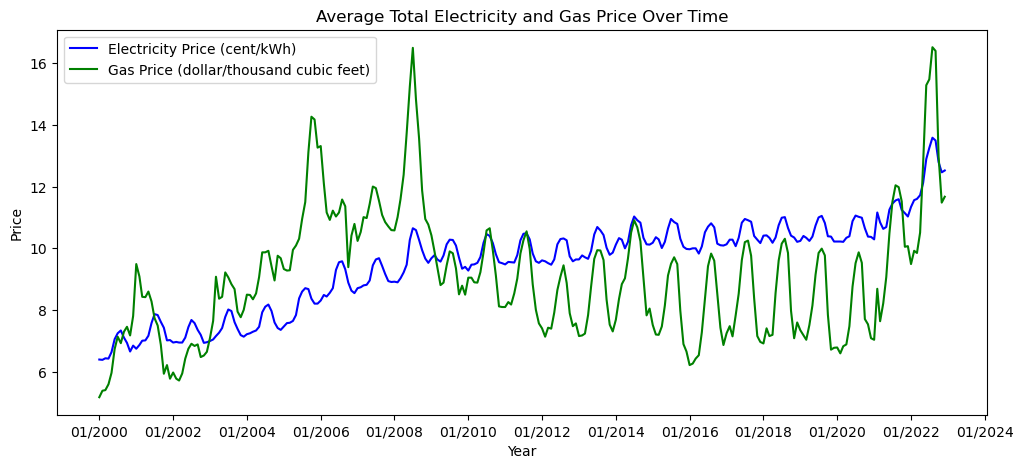

In [7]:
# Plot elec_price & gas_price columns over time
fig, ax = plt.subplots(figsize=(12, 5))

# Set the x-axis to be the period column as datetime
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.plot(df.index, df['elec_total'], label='Electricity Price (cent/kWh)', color=data_colors['elec_total'])
ax.plot(df.index, df['gas_total'], label='Gas Price (dollar/thousand cubic feet)', color=data_colors['gas_total'])

# Set title & labels
ax.set_title('Average Total Electricity and Gas Price Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Price')

# Show plot & legend
ax.legend()
plt.show()


Evidently, in the line chart displayed above, increases in Gas Prices and Electricity Prices occur in tandem with regular spikes in price each year, this plot also reflects the energy price difference between Winter and Summer as energy consumption and demand are higher during the colder months.
The demand and therefore price change every month, the demand levels for both Energy sources being similar throughout the year.

The 2006 Marker on the plot we can see a clear break in this pattern, with a spike in Gas prices and Electricity does not follow. The inconsistency may be a result of a particular national or global black swan event surrounding energy prices.

"In 2006, natural gas prices to electric utilities exceeded that of residual fuel oil, resulting in a 5-month shift away from the typical price pattern in which natural gas prices exceed that of residual fuel oil." - [EIA.GOV](https://www.eia.gov/naturalgas/weekly/archivenew_ngwu/2006/07_07/ngupdate.asp)

#### Correlation Coefficient 
To investigate the correlation coefficient over time I calculate the correlation coefficient yearly value below and store it in a new data frame.

Yearly correlation coefficients:
period            
2000    elec_total    0.77
2001    elec_total   -0.30
2002    elec_total    0.76
2003    elec_total    0.74
2004    elec_total    0.75
2005    elec_total    0.65
2006    elec_total   -0.19
2007    elec_total    0.79
2008    elec_total    0.82
2009    elec_total    0.55
2010    elec_total    0.87
2011    elec_total    0.97
2012    elec_total    0.97
2013    elec_total    0.95
2014    elec_total    0.87
2015    elec_total    0.92
2016    elec_total    0.94
2017    elec_total    0.94
2018    elec_total    0.89
2019    elec_total    0.93
2020    elec_total    0.98
2021    elec_total    0.91
2022    elec_total    0.95


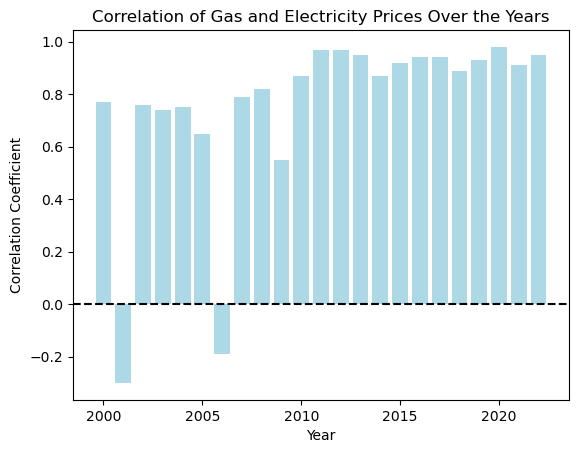

In [8]:
# Group by year and calculate the correlation coefficients to new df
corr_df = df.groupby(df.index.year)[['elec_total', 'gas_total']].corr()

# Get my correlation coefficients for just gas prices and electricity prices
elec_gas_corr = corr_df.iloc[corr_df.index.get_level_values(1) == 'elec_total']['gas_total']
elec_gas_corr = elec_gas_corr.round(2)

print('Yearly correlation coefficients:\n' + elec_gas_corr.to_string())

elec_gas_corr = elec_gas_corr.reset_index(level=1, drop=True)

# Create a bar chart of the correlation coefficients
fig, ax = plt.subplots()
ax.bar(elec_gas_corr.index, elec_gas_corr.values, color='lightblue')
ax.axhline(y=0, color='black', linestyle='--')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Correlation of Gas and Electricity Prices Over the Years')

# Display plot
plt.show()


For the most part, there is a high correlation for each of the years in the dataset between the average prices of both forms of energy, it is clear from the dataset that we have here are two outliers: 2001 and 2006. 

Interestingly upon further research of energy prices in the US around that period, issues had arisen as a result of market manipulation & a large gap between the increasing demand for electricity and the supply, leading to what some articles online have titled the  `2000-2001 Western Energy Crisis` where electricity prices in some states e.g. California is said to have increased up to 800%. 

#### Articles
- [Energy crisis of 2000/2001](https://www.nwcouncil.org/reports/columbia-river-history/energycrisis/)
- [Addressing the 2000-2001 Western Energy Crisis](https://www.ferc.gov/industries-data/electric/general-information/addressing-2000-2001-western-energy-crisis)

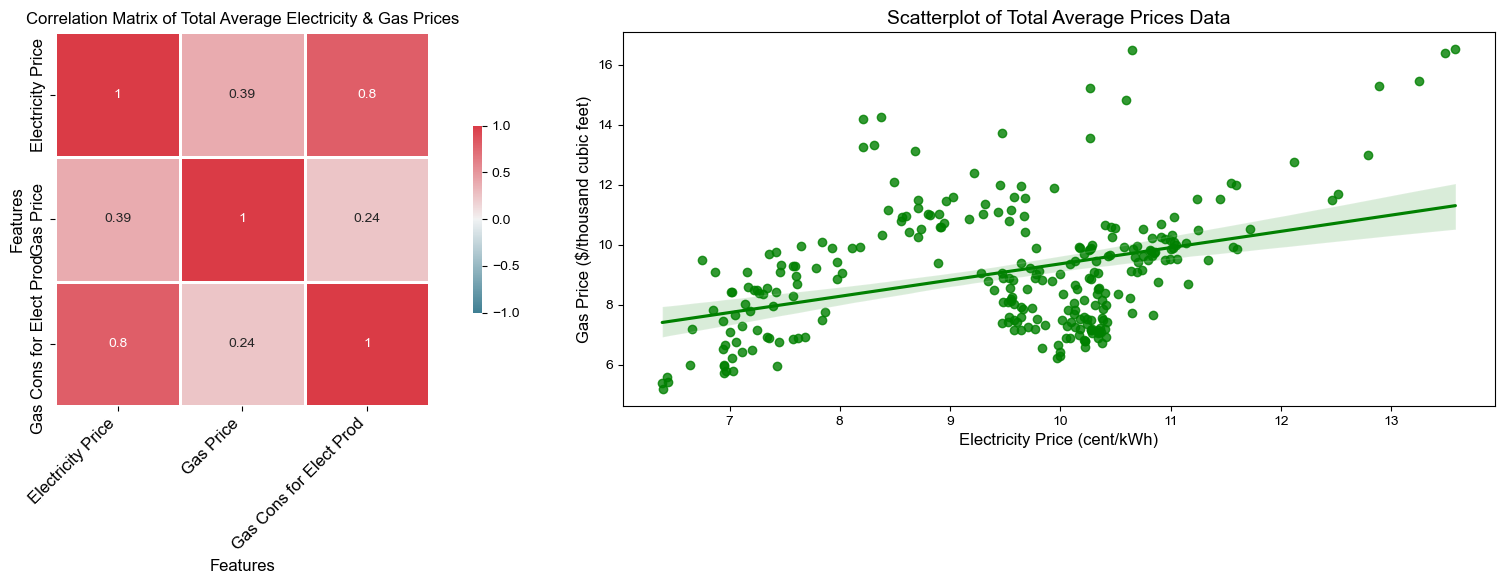

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))

# Create correlation matrix
corr_matrix = df[['elec_total', 'gas_total', 'gas_cons_forelec']].corr()

# Create heatmap with custom colors
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, vmin=-1, vmax=1, linewidths=1, linecolor='white', cbar_kws={"shrink": .5},
            ax=axs[0])

# Set title and axis labels
axs[0].set_title('Correlation Matrix of Total Average Electricity & Gas Prices', fontsize=fontsize)
axs[0].set_xlabel('Features', fontsize=fontsize)
axs[0].set_ylabel('Features', fontsize=fontsize)

# Set custom tick labels
tick_labels = ['Electricity Price', 'Gas Price', 'Gas Cons for Elect Prod']
axs[0].set_xticks([i+0.5 for i in range(len(tick_labels))])
axs[0].set_yticks([i+0.5 for i in range(len(tick_labels))])
axs[0].set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=fontsize)
axs[0].set_yticklabels(tick_labels, fontsize=fontsize)

# Create scatterplot 
sns.set(style="ticks")
scat = sns.regplot(x="elec_total", y="gas_total", data=df, color="green", ax=axs[1])
scat.set_xlabel('Electricity Price (cent/kWh)', fontsize=fontsize)
scat.set_ylabel('Gas Price ($/thousand cubic feet)', fontsize=fontsize)
scat.set_title("Scatterplot of Total Average Prices Data", fontsize=14)

plt.tight_layout()
plt.show()


From the plots above, a correlation can be drawn to support the idea that electricity follows natural gas prices, it is worth noting that there are a number of outliers on the scatterplot and large clusters near the middle of the plot.

Following on from the Bar chart used to visualise the correlation coefficient for each of the years separately using the monthly price data, the outliers in 2006 and 2001 are having a significant impact on the overall correlation coefficient between total gas and electricity prices at 0.38. 

## Electricity Price Analysis

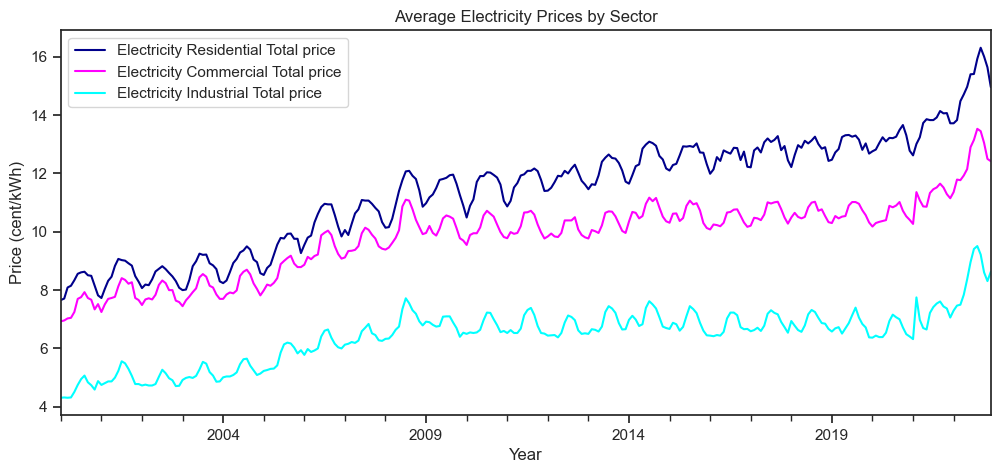

In [10]:
# Line chart to convey different sectors electricity prices
elec_prices = df[['elec_res', 'elec_comm', 'elec_ind']]

fig, ax = plt.subplots(figsize=(12, 5))
elec_prices.plot(ax=ax, color=data_colors)

ax.set_title('Average Electricity Prices by Sector')
ax.set_xlabel('Year')
ax.set_ylabel('Price (cent/kWh)')
ax.legend(labels=data_labels.values(), loc='upper left')
# Display Plot
plt.show()


The above line chart displays the average monthly price of Electricity for Residential, Commercial and Industrial Customers. Following a very similar path in all three cases.

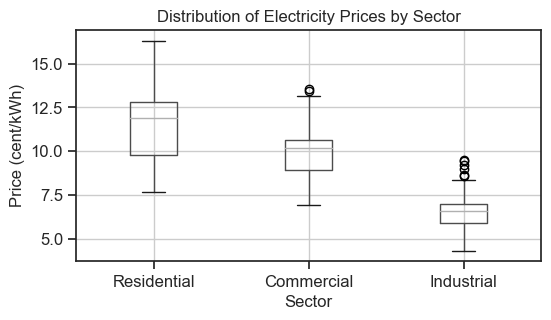

In [11]:
# Create Distribution BoxPlot of Sector Prices
ax = elec_prices.boxplot(figsize=(6,3), fontsize=fontsize)
ax.set_title('Distribution of Electricity Prices by Sector')
ax.set_xlabel('Sector')
ax.set_ylabel('Price (cent/kWh)', fontsize=fontsize)
ax = ax.set_xticklabels(['Residential', 'Commercial', 'Industrial']) 


## Gas Price Analysis

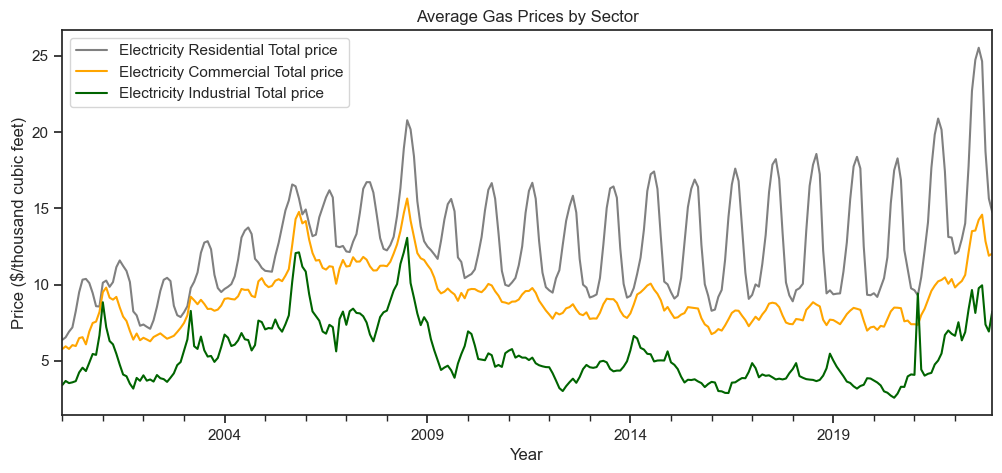

In [12]:
# Line chart to convey different sectors electricity prices
gas_prices = df[['gas_res', 'gas_comm', 'gas_ind']]

fig, ax = plt.subplots(figsize=(12, 5))
gas_prices.plot(ax=ax, color=data_colors)

ax.set_title('Average Gas Prices by Sector')
ax.set_xlabel('Year')
ax.set_ylabel('Price ($/thousand cubic feet)')
ax.legend(labels=data_labels.values(), loc='upper left')
# Display The Data via Line Chart
plt.show()


The above chart outlines the average monthly gas price for each sector: Residential, Industrial and Commercial. Interestingly we find that in recent years the price for residential consumers has been the most volatile.

In the first years of the dataset from 2000 - 2010 we can see the prices for each sector in the U.S. followed one another closely, in more recent years the Industrial sector, in particular, has benefited from a large gap in the price offered to residential consumers.

Most recent prices for Residential Natural Gas, for 2022, are the most expensive in the dataset.T

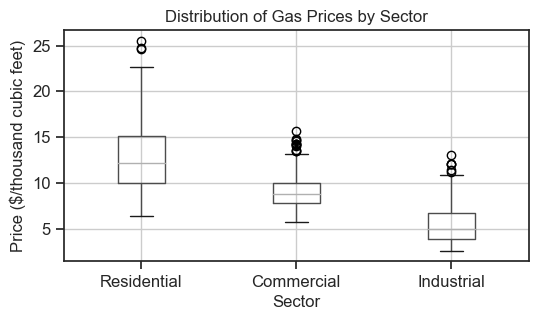

In [13]:
# Create Distribution BoxPlot of Sector Prices
ax = gas_prices.boxplot(figsize=(6,3), fontsize=fontsize)
ax.set_title('Distribution of Gas Prices by Sector')
ax.set_xlabel('Sector')
ax.set_ylabel('Price ($/thousand cubic feet)', fontsize=fontsize)
ax = ax.set_xticklabels(['Residential', 'Commercial', 'Industrial']) 


## Gas & Renewable Energy Consumption Trend Over the Years

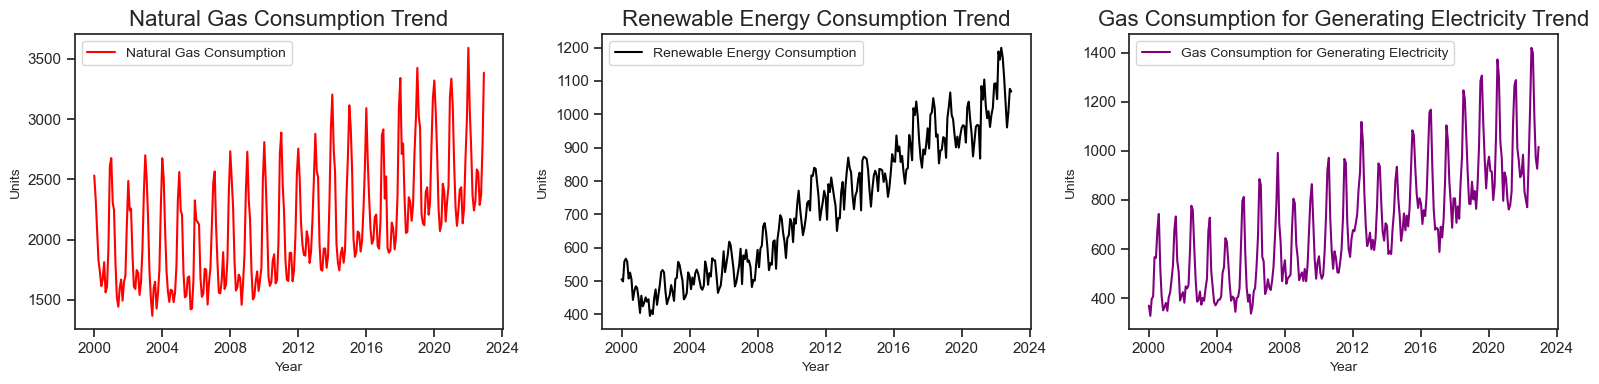

In [14]:
# Create 3 line charts to convey upward trend in energy consumption 
fig_size = (16, 4)
fontsize = 10

# Create two subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=fig_size)

# Loop to create a line chart for each data column
for i, col in enumerate(['nat_gas_consum', 'ren_energy_consum', 'gas_cons_forelec']):
    
    # Plot data in right subplot, using label and color dictionary
    axs[i].plot(df.index, df[col], label=data_labels[col], color=data_colors[col])
    
    # Set chart labels
    axs[i].set_title(f'{data_labels[col]} Trend', fontsize=16)
    axs[i].set_xlabel('Year', fontsize=fontsize)
    axs[i].set_ylabel(f'Units', fontsize=fontsize)
    
    axs[i].legend(fontsize=fontsize)
    fig.tight_layout()
    
plt.show()


Energy usage overall is on the rise over the past twenty years, all of the consumption trends outlined above align with this statement for the U.S. 

We also see a nearly two fold increase in the unit of Natural Gas being used to generate Electricity.

#### U.S. Natural Gas Consumption with the units being used for generating electricity

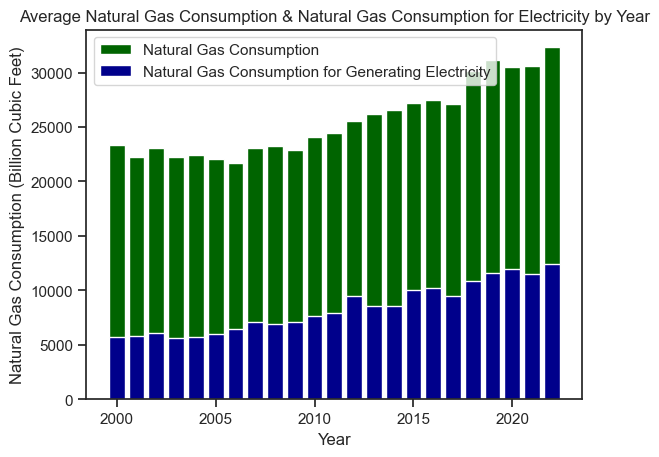

In [15]:
# Yearly Gas Consumption since 2000 Bar Chart
gas_consumption_by_year = df.groupby(df.index.year)['nat_gas_consum'].sum()
gas_for_elec_by_year = df.groupby(df.index.year)['gas_cons_forelec'].sum()

fig, ax = plt.subplots()
ax.bar(gas_consumption_by_year.index, gas_consumption_by_year, color='darkgreen', label='Natural Gas Consumption')
ax.bar(gas_for_elec_by_year.index, gas_for_elec_by_year, color='darkblue', label='Natural Gas Consumption for Generating Electricity')

ax.set_title('Average Natural Gas Consumption & Natural Gas Consumption for Electricity by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Natural Gas Consumption (Billion Cubic Feet)')
ax.legend()

plt.show()

Highlighted in the above bar chart, both the increase in Natural gas used by the U.S. and the increase in Natural Gas used to generate electricity. Both trends increasing in a similar capacity.

#### Renewable Energy Consumption Vs. Production

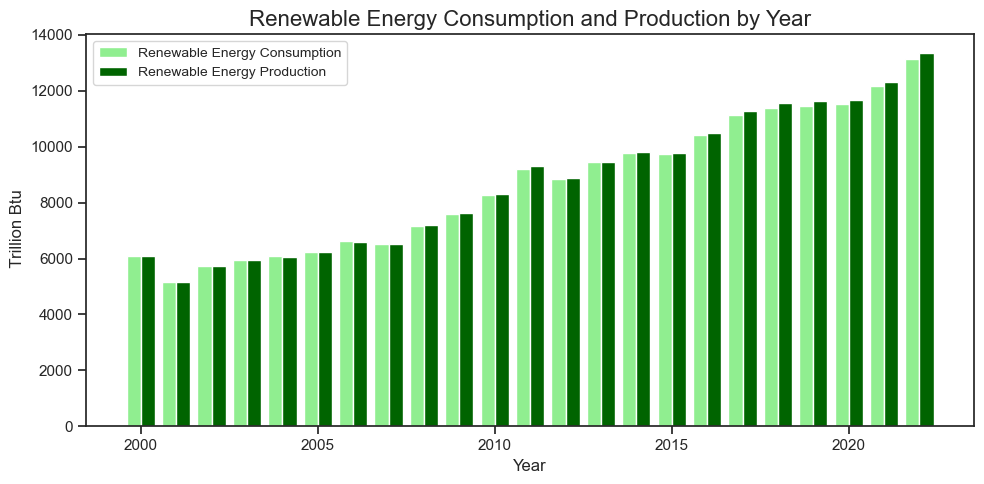

In [16]:
# Yearly Renewable Energy Consumption since 2000 Bar Chart
# Group by year
ren_consumption_by_year = df.groupby(df.index.year)['ren_energy_consum'].sum()
ren_production_by_year = df.groupby(df.index.year)['ren_energy_prod'].sum()


fig, ax = plt.subplots(figsize=(10, 5))
width = 0.4  # the width of the bars

# Plot as side-by-side bars
ax.bar(ren_consumption_by_year.index - width/2, ren_consumption_by_year, width, label='Renewable Energy Consumption', color='lightgreen')
ax.bar(ren_production_by_year.index + width/2, ren_production_by_year, width, label='Renewable Energy Production', color='darkgreen')

ax.set_title('Renewable Energy Consumption and Production by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel(' Trillion Btu', fontsize=12)
ax.legend(fontsize=10)
fig.tight_layout()

plt.show()


From the above plot, it is evident that the Consumption and production of renewable energy have both increased significantly, following one another closely. In other words, the supply of renewable energy is being utilised each year with little import/export needed in the U.S.

This also suggests a high demand for renewable energy, from research and from this analysis renewable energy is prioritised over fossil fuels, they are utilised first when possible before using fossil fuels. This would suggest that any further increase in renewable production would be met with a similar increase in consumption.

## Conclusion

In this analysis of the U.S. Energy Sector, utilising the API provided by the U.S. Energy Information Administration, we investigated the average monthly pricing data for both Natural Gas and Electricity, including the pricing for three different sectors: Commercial, Residential & Industrial. Along with this analysis, we also took a look at some interesting data points related to the different forms of consumption and the trend since January 2000.

#### Energy Consumption In The U.S.

The surging demand for energy will continue to grow as it has done over the last two decades, a number of different factors feed into this as society increasingly becomes reliant on technology, the population continues to increase and global emerging economies continue to grow rapidly. The analysis of the U.S. energy data above conveys a positive picture of the current trend in this industry, with renewable energy demand and production continuously growing.
Although Natural Gas consumption has steadily increased over recent years in the U.S., "Natural gas emits 50 to 60 percent less carbon dioxide (CO2) when combusted in a new, efficient natural gas power plant compared with emissions from a typical new coal plant."[1] When compared to other fossil fuels Natural Gas posseses fewer negative consequences to the environment. A noticeable trend in the rise of Natural Gas used to produce Electricity is also evident in the above data, indicating a further need for Renewable energy sources that produce electricity in the U.S.

#### Electricity Vs. Gas Pricing Data

The analysis done on the average price data supports the correlation between the prices of the pair. Some events, regional or global factors might impact this dramatically. Considering that it is evident from the above both pricing data have followed similar trends over time, it is said that electricity is priced by Natural Gas "sets the price of electricity, because the electricity price in every half hour period is set by the marginal cost of the last generating unit to be turned off to meet demand – which is invariably a gas power plant with high marginal costs." [2]
Another factor adding to the correlation of the prices may be a result of the same variables affecting the monthly price of the pair, for example as energy demand increases or decreases due to the time of year or the current weather conditions in the region.


#### Further Research & Restrictions

One issue that surfaced in implementing the API was incomplete data. For example, some of the requests contained empty data, for example, the Transport sector data returned null for all price values, along with this there was no total Average Natural Gas price available on the API, for this I created a workaround to suffice and use the average of the three sectors that were available.
This may have been a result of using the newer version of the Energy API v2, the organisation EIA retired its legacy API (APIv1) on March 13th, 2023.

For further study on the chosen topic, there are many potential avenues of analysis one could go down to investigate the Energy market further.

- The same API provides state-by-state data, one could compare different states and their usage trends: e.g. Coastal states and their renewable energy consumption vs. inland states (higher wind power, access to wave power)
- One could use further historic data and go back further in time to investigate energy usage and prices.
- Examine any correlations between energy prices and other economic indicators, such as GDP or inflation rates.
- Examine any correlations between energy prices and weather conditions.
- The impact of government policies and regulations on the energy market, and how they have evolved over time.
- Finally, it might be interesting to study the energy market in other countries or regions and compare their trends and patterns to those observed in the U.S..

### Refferences

- [1] [UCSUSA](https://www.ucsusa.org/resources/environmental-impacts-natural-gas)
- [2] [Why does the price of gas drive electricity prices, including renewables?](https://www.goodenergy.co.uk/why-does-the-price-of-gas-drive-electricity-prices-including-renewables/)